In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import truncnorm
import time
from sklearn.neighbors import BallTree
import os
import random
import os

## Read Car Data

In [252]:
car_data = pd.read_csv('/Users/fergushathorn/Documents/MOPTA/mopta/mopta/data/MOPTA2023_car_locations.csv', header=None)
car_data = np.array(car_data)

## Define Individual Structures

In [253]:
n_individual = 600 # stations in an individual
pop_size = 100 # number of individuals
x_max = 290 # size of search space on x axis
y_max = 150 # size of search space on y axis
max_chargers = 8 # max number of chargers at a station

# cost parameters
driving_cost_per_mile = 0.041 * 10000
charging_cost_per_mile = 0.0388
construction_cost_per_station = 5000
maintenance_fee_per_charger = 500
no_assignment_penalty = 5000
exceed_range_penalty = 5000

# define the PSO parameters
options = {'c1': 0.07, 'c2': 0.13, 'w':0.85}

## Distributions for sampling points in the search space and velocities

In [254]:
# uniform distribution for generating random points in the search space
ud_x = uniform(0, x_max)
ud_y = uniform(0, y_max)

# uniform distribution for generating random number between 0 and 1
ud = uniform(0,1)

class Ranges:
    def __init__(self, ranges):
        self.ranges = ranges
        
nd = norm(1, 0.5) # normal distribution for sampling velocities

## Creating the population

In [255]:
class Individual:

    def __init__(self, ident, positions, chargers, velocities):
        self.ident = ident
        self.positions = positions # numpy array of x,y positions of all stations
        self.chargers = chargers # numpy array of number of chargers per station
        self.velocities = velocities # numpy array of x,y velocity of each station
        self.best_positions = positions # numpy array of best configuration for the station
        self.cost = 0
        self.vehicle_assignments = np.tile(None, car_data.shape[0])
        self.assignment_proportion = None
        self.station_counter = {i : 0 for i in range(self.positions.shape[0])}
        self.distance_to_station = np.tile(None, car_data.shape[0])
        self.charging_costs = np.tile(None, car_data.shape[0])
        self.charger_costs = None
        self.station_costs = None
        self.driving_costs = np.tile(None, car_data.shape[0])
        self.total_cost_no_penalty = None
        self.previous_positions = positions

    def update_positions(self, global_best_stations, g:list, options=options): # global best stations must be a numpy array with x,y coords of the best global configuration
        # c1 = (0.08 - 0.15) * g[0] / g[1] + 0.15
        # c2 = (0.15 - 0.08) * g[0] / g[1] + 0.08
        self.previous_positions = self.positions.copy()
        
        inertia_components = options['w'] * (self.velocities)
        cognitive_components = ud.rvs(1) * options['c1'] * (self.best_positions - self.positions)
        social_components = ud.rvs(1) * options['c2'] * (global_best_stations - self.positions)
        
        new_velocities = inertia_components + cognitive_components + social_components
        new_velocities[new_velocities[:,0] > 1, 0] = 1#max(0.01, (options['w']**g[0]))
        new_velocities[new_velocities[:,1] > 1, 1] = 1#max(0.01, (options['w']**g[0]))
        new_velocities[new_velocities[:,0] < -1, 0] = -1#max(0.01, (options['w']**g[0]))
        new_velocities[new_velocities[:,1] < -1, 1] = -1#max(0.01, (options['w']**g[0]))
        new_positions = new_velocities + self.positions
        
        new_positions.reshape(n_individual, 2)
        
        self.positions = new_positions
        self.velocities = new_velocities


## Function for generating the population

In [256]:
def gen_pop(pop_size, car_data_anchor):
    population = {} # empty dictionary to fill with individuals to make population
    for i in range(pop_size):
        # generating random x,y positions for the individual stations
      
        # uniform distribution for generating random points in the search space
        spawn_radius = 10
        ud_x = uniform(-spawn_radius, spawn_radius)
        # ud_y = uniform(-spawn_radius, spawn_radius)
      
        noise = ud_x.rvs((n_individual,2))
      
        positions = np.zeros_like(noise)
      
        for s in range(car_data_anchor.shape[0]):
            positions[s] = noise[s] + car_data_anchor[s]
        velocities=nd.rvs(size=(n_individual, 2)) * np.random.choice([1,-1], size=(n_individual, 2)) # sampling velocities from random dist
        population.update({i : Individual(ident=i,
                                          positions=positions.copy(),
                                          chargers=np.random.choice(list(range(1,9))),
                                          velocities=velocities)}
                          )
    return population

## Sampling vehicle ranges

In [257]:
# get sample of vehicle ranges
min_range = 20
max_range = 250
mean_range = 100
sd_range = 50

# sample ranges for each vehicle
def get_samples(min_range=min_range,
                max_range=max_range,
                mean_range=mean_range,
                sd_range=sd_range):
    pd = truncnorm((min_range - mean_range) / sd_range, 
                   (max_range - mean_range) / sd_range, 
                   loc=mean_range, scale=sd_range)
    samples = pd.rvs(size=(car_data.shape[0], 1000))
    samples_aggregated = np.mean(samples, axis=1)

    return samples_aggregated

# ranges sampled
samples = get_samples()
rng = Ranges(ranges=samples)

## Utility functions

In [258]:
def compute_visiting_probability(ranges:np.array, lam:float=0.012):
    return np.exp(-lam**2 * (ranges - 20)**2 )

# Calculate the pairwise distances between points in the two arrays
def calculate_distance(car_location, station_location):
    return np.linalg.norm(car_location - station_location, axis=1)

## KNN

In [413]:
def KNN(population, K, gen, local_best_scores):
    S = 16
    for individual in range(pop_size):
          
        if gen % 1 == 0:
            ranges = get_samples() # rng.ranges#
            rng.ranges = ranges
        else:
            ranges = rng.ranges
        
      
        # get visiting probabilities
        c = compute_visiting_probability(ranges)
        # number of vehicles per batch
        v_b = np.round(c * 10, 0)
        # exclude vehicles with a low probability of charging
        exclusion = 0 # 0.2*10
      
        # vehicle batches which have a strong enough probability of visiting a charger
        applicable_vehicles = np.array([v for v in range(v_b.shape[0]) if v_b[v] >= exclusion])
        applicable_ranges = ranges[applicable_vehicles]
      
        v_b = v_b[applicable_vehicles]
      
        vehicle_positions = car_data[applicable_vehicles]
      
        # station positions
        station_dict = {j : population[individual].positions[j] for j in range(n_individual)}
        # station position array
        station_positions = np.array([station_dict[i] for i in station_dict])
      
        # find the indices of applicable stations
        tree = BallTree(station_positions, leaf_size=2)
        # ind_range = tree.query_radius(vehicle_positions, r=applicable_ranges) # indices of stations that are in range of vehicles
        dist, ind_closest = tree.query(vehicle_positions, k=K) # indices of closest stations
      
        # dictionary of how many chargers at each station
        vehicle_assignments = population[individual].vehicle_assignments#{i : None for i in range(vehicle_positions.shape[0])}
#       # distance_to_station = []
        # charging_costs = []
        # driving_costs = []
      
        # shuffle_vehicle_indices = list(range(vehicle_positions.shape[0]))
        # random.shuffle(shuffle_vehicle_indices)
      
        # assign vehicles in order of demand, i.e. higher demand nodes get assigned first (means higher prob of charging)
        shuffle_vehicle_indices = np.argsort(v_b)[::-1]
            
        # for each vehicle, find a station with availability and add the vehicle batch to that station
        for v in shuffle_vehicle_indices:
            # first check if the assigned station has moved significantly
            if gen == 0:
                stations_in_use = [ind for ind in ind_closest[v] if (population[individual].station_counter[ind] + v_b[v] <= S and population[individual].station_counter[ind] > 0)]
                stations_not_in_use = [ind for ind in ind_closest[v] if ind not in stations_in_use]
                closest_stations = stations_in_use + stations_not_in_use
                for ind in range(len(closest_stations)):
                    if population[individual].station_counter[closest_stations[ind]] + v_b[v] <= S: 
                        population[individual].station_counter[closest_stations[ind]] += v_b[v]
                        vehicle_assignments[v] = closest_stations[ind]
                        population[individual].distance_to_station[v] = dist[v][ind]
                        population[individual].charging_costs[v] = charging_cost_per_mile * v_b[v] * (250 - applicable_ranges[v] - dist[v][ind])
                        population[individual].driving_costs[v] = driving_cost_per_mile * v_b[v] * dist[v][ind]
                        break
            elif (np.linalg.norm(population[individual].positions[vehicle_assignments[v]] - population[individual].previous_positions[vehicle_assignments[v]])) > 1 or (random.random() < 0.1) or (np.linalg.norm(population[individual].positions[vehicle_assignments[v]] - vehicle_positions[v]) > 30):
                # unassign the vehicle station pair
                population[individual].station_counter[vehicle_assignments[v]] = max(population[individual].station_counter[vehicle_assignments[v]] - v_b[v], 0)
                vehicle_assignments[v] = None
                # then check if any of the nearby stations are already in use
                stations_in_use = [ind for ind in ind_closest[v] if (population[individual].station_counter[ind] + v_b[v] <= S and population[individual].station_counter[ind] > 0)]
                stations_not_in_use = [ind for ind in ind_closest[v] if ind not in stations_in_use]
                closest_stations = stations_in_use + stations_not_in_use
                for ind in range(len(closest_stations)):
                    if population[individual].station_counter[closest_stations[ind]] + v_b[v] <= S: 
                        population[individual].station_counter[closest_stations[ind]] += v_b[v]
                        vehicle_assignments[v] = closest_stations[ind]
                        population[individual].distance_to_station[v] = dist[v][ind]
                        population[individual].charging_costs[v] = charging_cost_per_mile * v_b[v] * (250 - applicable_ranges[v] - dist[v][ind])
                        population[individual].driving_costs[v] = driving_cost_per_mile * v_b[v] * dist[v][ind]
                        break
                    elif ind == len(closest_stations)-1:
                        vehicle_assignments[v] = None
        
        assigned = sum(1 for i in vehicle_assignments if i != None)
        # calculate the cost
        # driving cost
        driving_cost = sum(population[individual].driving_costs)
        # charging cost
        charging_cost = sum(population[individual].charging_costs)
        # station cost, charger cost
        
        
        
        total_chargers = sum(np.ceil(population[individual].station_counter[s] / 2) for s in population[individual].station_counter)
        population[individual].chargers = total_chargers
        population[individual].charger_cost = population[individual].chargers * maintenance_fee_per_charger
        
        station_cost = 0
        for s in population[individual].station_counter:
            station_cost += construction_cost_per_station * (population[individual].station_counter[s] > 0)
        charger_cost = maintenance_fee_per_charger * total_chargers
            
        population[individual].station_cost = station_cost
        population[individual].charger_cost = charger_cost
                
        pct_assigned = assigned/vehicle_positions.shape[0]
        penalty_cost_no_assignment_made = (vehicle_positions.shape[0] - assigned) * no_assignment_penalty # no_assignment_penalty * (vehicle_positions.shape[0] - assigned) # (1-pct_assigned) * 

        total_cost_no_penalty = driving_cost + charging_cost + station_cost + charger_cost
        total_cost = total_cost_no_penalty + penalty_cost_no_assignment_made # + distance_cost # penalty_cost_exceeding_range
      
        population[individual].cost = total_cost
        population[individual].assignment_proportion = pct_assigned
#         population[individual].station_counter = station_counter
        population[individual].vehicle_assignments = vehicle_assignments.copy()
#         population[individual].distance_to_station = distance_to_station
        
      
        if total_cost < local_best_scores[individual]:
            local_best_scores[individual] = total_cost
            population[individual].best_positions = population[individual].positions
        population[individual].total_cost_no_penalty = total_cost_no_penalty
      

## Evaluate function

In [414]:
def evaluate(population, vehicles, global_best_score, global_best_stations, local_best_scores, K, global_best_station_counter, global_best_index, global_best_assignments, gen):
    '''
    The vehicle-->station assignments are be made in this function and the cost is evaluated
    '''
    
    # print('Solving assignment problem...')
    KNN(population, K, gen, local_best_scores)
    # print('Assignment solved for population')
    
    population_fitness = []
    population_fitness_no_penalty = []
    for i in range(pop_size):
        population_fitness.append(population[i].cost)
        population_fitness_no_penalty.append(population[i].total_cost_no_penalty)
    
    if min(population_fitness) <= global_best_score:
        global_best_score = min(population_fitness)
        global_best_stations = population[np.argmin(population_fitness)].positions
        global_best_station_counter = population[np.argmin(population_fitness)].station_counter
        global_best_index = np.argmin(population_fitness)
        global_best_assignments = population[np.argmin(population_fitness)].vehicle_assignments
      # print('Updated global best')
    # print("Evaluation Complete\n----------------------------")
    
    return global_best_score, global_best_stations, global_best_station_counter, global_best_index, global_best_assignments, local_best_scores, population_fitness, population_fitness_no_penalty

# SWARM

In [419]:
bests = []
local_bests = []
mean_prop = []
pop_fitness = []
pop_fitness_no_penalty = []
pop_size = 100
car_anchors = np.random.choice(list(range(car_data.shape[0])), n_individual)
car_data_anchor = car_data[car_anchors] #np.array([ud_x.rvs(600), ud_y.rvs(600)]).reshape(600,2) 
population = gen_pop(pop_size, car_data_anchor)
generations = 100
K = 100
rand = False
global_best_stations = car_data_anchor #np.array([[ud_x.rvs(1)[0],ud_y.rvs(1)[0]] for i in range(n_individual)]) # position of every station in the global best
# global best score
global_best_score = 1000000000
global_best_station_counter, global_best_index = None,None
global_best_assignments = None
local_best_scores = [1e9 for i in range(pop_size)] # storing local best scores (not positions)
start = time.time()
particle_movement = []
for gen in range(generations):
    global_best_score, global_best_stations, global_best_station_counter, global_best_index, global_best_assignments, local_best_scores, population_fitness, population_fitness_no_penalty = evaluate(population, car_data, global_best_score, global_best_stations, local_best_scores, K, global_best_station_counter, global_best_index, global_best_assignments, gen)
    bests.append(global_best_score)
    local_bests.append(np.mean(local_best_scores))
    pop_fitness.append(population_fitness)
    pop_fitness_no_penalty.append(population_fitness_no_penalty)
    if gen % 10 == 0:
        print(gen, np.mean(pop_fitness_no_penalty))
      
    if not rand:
        for ind in population:
            population[ind].update_positions(global_best_stations, [gen, generations])
    else:
        population = gen_pop(pop_size, car_data_anchor)
    
    props = []
    gen_movement = []
    for i in range(pop_size):
        props.append(population[i].assignment_proportion)
        gen_movement.append(population[i].positions)
    
    if not rand: 
        mean_prop.append(np.mean(props))
    particle_movement.append(gen_movement)

print("{:.3f} seconds".format(time.time()-start))
print("Overall improvement of {:.2f}%".format(100*(np.mean(pop_fitness[0]) - np.mean(pop_fitness[-1]))/np.mean(pop_fitness[0])))
print('Best result: {:.2f}'.format(global_best_score))


0 6407238.65440728
10 6258378.387749151
20 6207196.70827808
30 6175468.877454678
40 6152289.703733334
50 6133895.019436885
60 6117699.10865389
70 6104806.953268862
80 6094352.195051508
90 6086085.517438264
1713.032 seconds
Overall improvement of 6.05%
Best result: 5915835.73


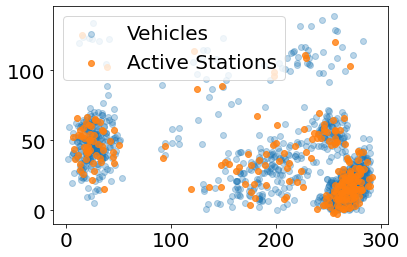

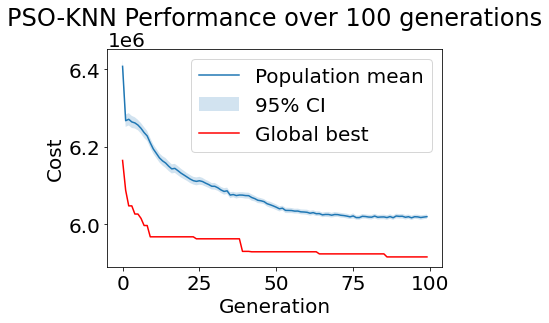

In [420]:
active_stations = np.array([global_best_stations[i] for i in range(global_best_stations.shape[0]) if global_best_station_counter[i] > 0])
active_stations_indices = [i for i in range(global_best_stations.shape[0]) if global_best_station_counter[i] > 0]
dormant_stations = np.array([global_best_stations[i] for i in range(global_best_stations.shape[0]) if global_best_station_counter[i] == 0])

plt.scatter(car_data[:,0], car_data[:,1], label='Vehicles', alpha=0.3)
plt.scatter(active_stations[:,0], active_stations[:,1], alpha=0.8, label='Active Stations')
# plt.scatter(dormant_stations[:,0], dormant_stations[:,1], alpha=0.3, label='Dormant Stations')
plt.legend()
plt.show()

# pop_fitness = np.array(pop_fitness)
mu = np.mean(pop_fitness, axis=1)
sig = np.std(pop_fitness, axis=1)
plt.title('PSO-KNN Performance over {} generations'.format(generations))
plt.ylabel('Cost')
plt.xlabel('Generation')
plt.plot(mu, label='Population mean')
plt.fill_between(range(generations), mu-2*sig/np.sqrt(pop_size), mu+2*sig/np.sqrt(pop_size), alpha=0.2, label='95% CI')
plt.plot(bests, '-r', label='Global best')
plt.legend()
plt.show()

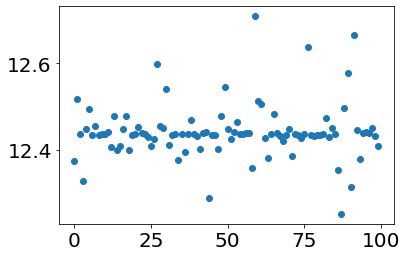

In [389]:
# Distance that x percentile of vehicles must travel to charge
plt.scatter(range(pop_size), [np.percentile(population[i].distance_to_station, 99) for i in range(pop_size)])

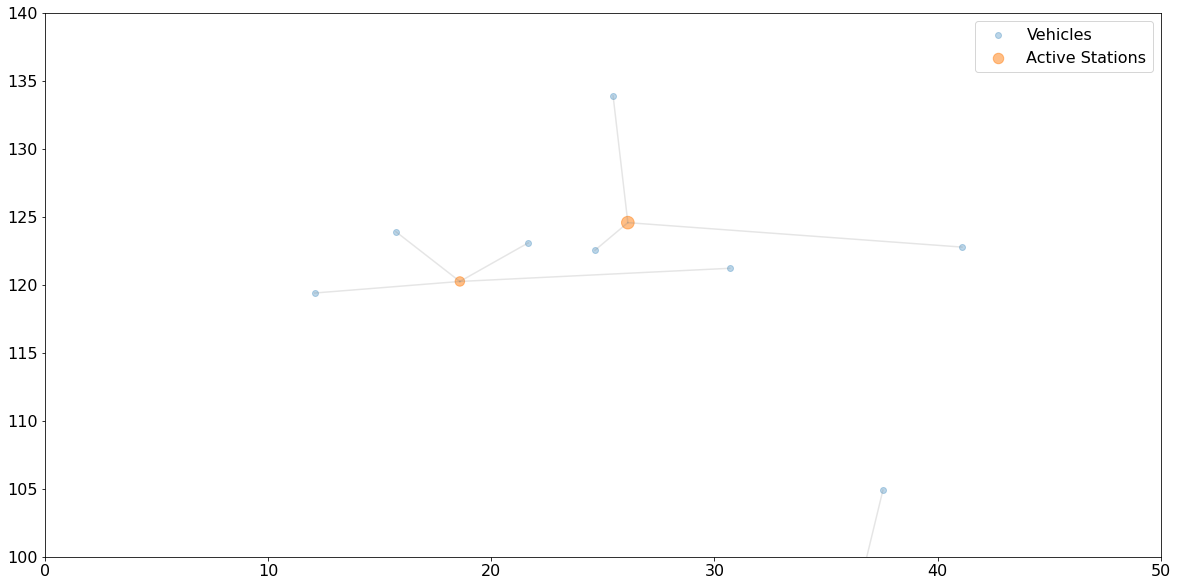

In [330]:
sz = np.array([global_best_station_counter[i] for i in range(global_best_stations.shape[0]) if global_best_station_counter[i] > 0])
sz_norm = (np.tile(max(sz), sz.shape[0]) - sz) / (np.tile(max(sz), sz.shape[0]) - np.tile(min(sz), sz.shape[0]))
plt.figure(figsize=(20,10))
plt.scatter(car_data[:,0], car_data[:,1], label='Vehicles', alpha=0.3)
plt.scatter(active_stations[:,0], active_stations[:,1], alpha=0.5, label='Active Stations', s=sz * 10)
for i, assignment in enumerate(global_best_assignments):
    plt.plot([car_data[i][0], global_best_stations[assignment][0]], [car_data[i][1], global_best_stations[assignment][1]], color='grey', alpha=0.2) 
plt.legend()

# plt.xlim(0, 50)  # Adjust the range as needed
# plt.ylim(100, 140)  # Adjust the range as needed
plt.show()

## Swarm Experiment

In [324]:
global_best_score_experiment, global_best_stations_experiment, global_best_station_counter_experiment, global_best_index_experiment, global_best_assignments_experiment, local_best_scores_experiment, population_fitness_experiment, population_fitness_no_penalty_experiment = [],[],[],[],[],[],[],[]
reps = 10

for swarm in range(reps):
    bests = []
    local_bests = []
    mean_prop = []
    pop_fitness = []
    pop_fitness_no_penalty = []
    pop_size = 100
    car_anchors = np.random.choice(list(range(car_data.shape[0])), n_individual)
    car_data_anchor = car_data[car_anchors] #np.array([ud_x.rvs(600), ud_y.rvs(600)]).reshape(600,2) 
    population = gen_pop(pop_size, car_data_anchor)
    generations = 100
    K = 100
    rand = False
    global_best_stations = car_data_anchor #np.array([[ud_x.rvs(1)[0],ud_y.rvs(1)[0]] for i in range(n_individual)]) # position of every station in the global best
    global_best_score = 1000000000
    global_best_station_counter, global_best_index = None,None
    global_best_assignments = None
    local_best_scores = [1e9 for i in range(pop_size)] # storing local best scores (not positions)
    start = time.time()
    particle_movement = []
    for gen in range(generations):
        global_best_score, global_best_stations, global_best_station_counter, global_best_index, global_best_assignments, local_best_scores, population_fitness, population_fitness_no_penalty = evaluate(population, car_data, global_best_score, global_best_stations, local_best_scores, K, global_best_station_counter, global_best_index, global_best_assignments, gen)
        bests.append(global_best_score)
        local_bests.append(np.mean(local_best_scores))
        pop_fitness.append(population_fitness)
        pop_fitness_no_penalty.append(population_fitness_no_penalty)

        if not rand:
            for ind in population:
                population[ind].update_positions(global_best_stations, [gen, generations])
        else:
            population = gen_pop(pop_size, car_data_anchor)

        props = []
        gen_movement = []
        for i in range(pop_size):
            props.append(population[i].assignment_proportion)
            gen_movement.append(population[i].positions)

        if not rand: 
            mean_prop.append(np.mean(props))
        particle_movement.append(gen_movement)
    
    global_best_score_experiment.append(global_best_score) 
    global_best_stations_experiment.append(global_best_stations) 
    global_best_station_counter_experiment.append(global_best_station_counter) 
    global_best_index_experiment.append(global_best_index) 
    global_best_assignments_experiment.append(global_best_assignments) 
    local_best_scores_experiment.append(local_best_scores) 
    population_fitness_experiment.append(pop_fitness) 
    population_fitness_no_penalty_experiment.append(pop_fitness_no_penalty)
    
    print("{:.3f} seconds".format(time.time()-start))
    print("Overall improvement of {:.2f}%".format(100*(np.mean(pop_fitness[0]) - np.mean(pop_fitness[-1]))/np.mean(pop_fitness[0])))
    print('Best result: {:.2f}'.format(global_best_score))

274.754 seconds
Overall improvement of 7.14%
Best result: 5964122.23
275.031 seconds
Overall improvement of 5.94%
Best result: 5856517.85
298.207 seconds
Overall improvement of 5.48%
Best result: 5889995.00
297.330 seconds
Overall improvement of 6.78%
Best result: 5910709.58
297.750 seconds
Overall improvement of 7.76%
Best result: 6088409.79
289.652 seconds
Overall improvement of 6.00%
Best result: 5913744.18
297.485 seconds
Overall improvement of 3.99%
Best result: 6014909.09
292.760 seconds
Overall improvement of 6.52%
Best result: 5695620.68
283.853 seconds
Overall improvement of 6.79%
Best result: 5812765.24
268.829 seconds
Overall improvement of 6.22%
Best result: 5973643.25


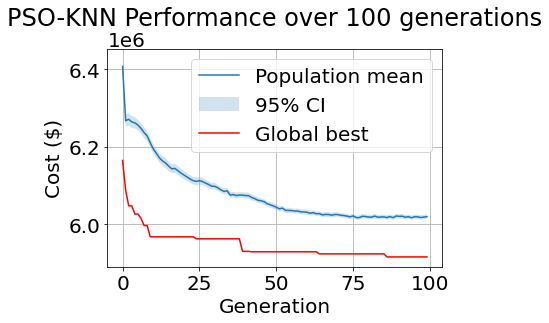

In [421]:
# a = np.array(population_fitness_experiment)
# b = np.zeros((generations, reps))
# for i in range(a.shape[0]):
#     b[:, i] = np.mean(a[i], axis=1)
b = pop_fitness
mu = np.mean(b, axis=1)
sig = np.std(b, axis=1)
plt.title('PSO-KNN Performance over {} generations'.format(generations))
plt.ylabel('Cost ($)')
plt.xlabel('Generation')
plt.plot(mu, label='Population mean')
plt.fill_between(range(generations), mu-2*sig/np.sqrt(pop_size), mu+2*sig/np.sqrt(pop_size), alpha=0.2, label='95% CI')
plt.plot(bests, '-r', label='Global best')
plt.legend()
plt.grid(True)
plt.show()

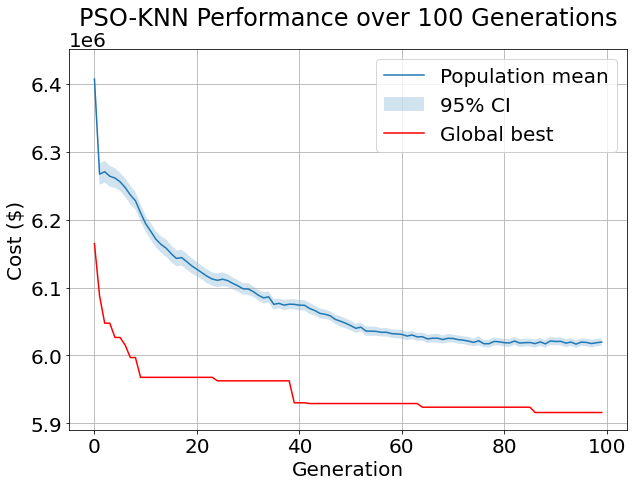

In [423]:
font_size = 20
header_font_size = 24

# Set font size
plt.rcParams['font.size'] = font_size

# Create the plot
plt.figure(figsize=(10, 7))
plt.title('PSO-KNN Performance over {} Generations'.format(generations), fontsize=header_font_size)
plt.ylabel('Cost ($)', fontsize=font_size)
plt.xlabel('Generation', fontsize=font_size)
plt.plot(mu, label='Population mean')
plt.fill_between(range(generations), mu - 2 * sig / np.sqrt(pop_size), mu + 2 * sig / np.sqrt(pop_size), alpha=0.2, label='95% CI')
plt.plot(bests, '-r', label='Global best')
plt.legend()
plt.grid(True)
plt.savefig("/Users/fergushathorn/Documents/MOPTA/submission/results/generational3.png", dpi=300)
# Show the plot
plt.show()

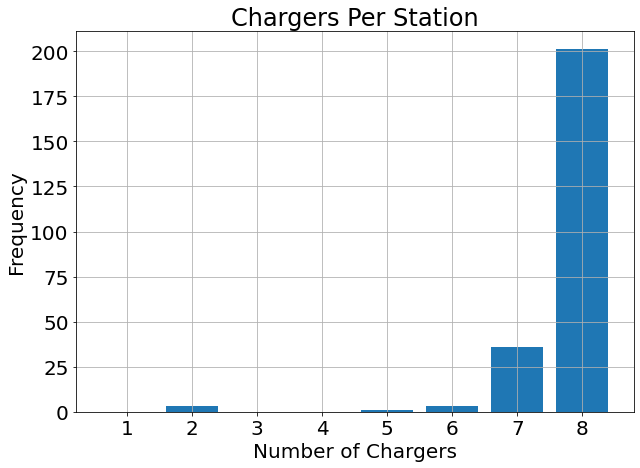

In [387]:
gb = global_best_station_counter_experiment[-2]
s_counter = [max(np.ceil(gb[i] / 2), 1) for i in gb if gb[i] > 0]

font_size = 20
header_font_size = 24

counts = np.bincount(s_counter)

plt.figure(figsize=(10, 7))

# Set font size
plt.rcParams['font.size'] = font_size

# Create a bar plot
plt.bar(range(1, len(counts)), counts[1:], align='center')

plt.title('Chargers Per Station', fontsize=header_font_size)
plt.xlabel('Number of Chargers')
plt.ylabel('Frequency')
plt.xticks(range(1,len(counts)))
plt.grid(True)
plt.savefig("/Users/fergushathorn/Documents/MOPTA/submission/results/chargers.png", dpi=300)
plt.show()

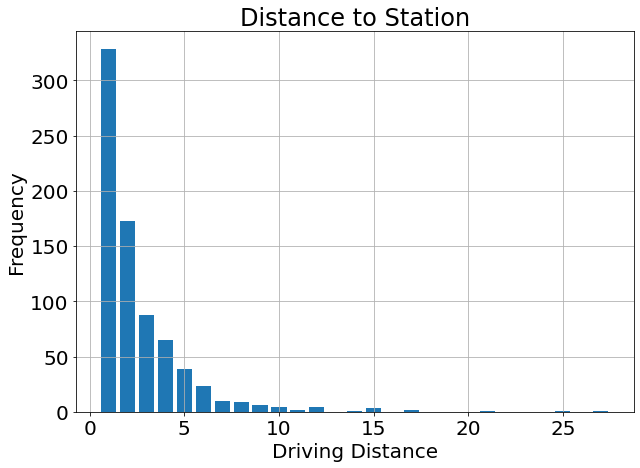

In [406]:
counts = np.bincount(list(population[0].distance_to_station))

plt.figure(figsize=(10, 7))

# Set font size
plt.rcParams['font.size'] = font_size

font_size = 20
header_font_size = 24

# Create a bar plot
plt.bar(range(1, len(counts)), counts[1:], align='center')

plt.title('Distance to Station', fontsize=header_font_size)
plt.xlabel('Driving Distance')
plt.ylabel('Frequency')
# plt.xticks(range(1,len(counts)))
plt.grid(True)
plt.savefig("/Users/fergushathorn/Documents/MOPTA/submission/results/distances.png", dpi=300)
plt.show()

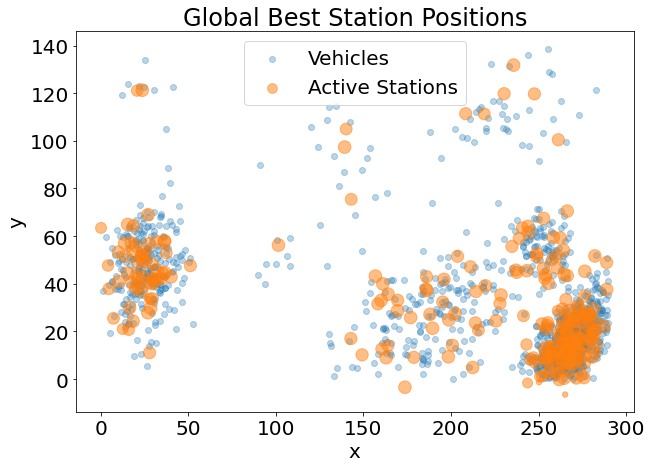

In [404]:
sz = np.array([global_best_station_counter_experiment[-2][i] for i in range(global_best_stations_experiment[-2].shape[0]) if global_best_station_counter_experiment[-2][i] > 0])
sz_norm = (np.tile(max(sz), sz.shape[0]) - sz) / (np.tile(max(sz), sz.shape[0]) - np.tile(min(sz), sz.shape[0]))
plt.figure(figsize=(10,7))

active_stations = np.array([global_best_stations_experiment[-2][i] for i in range(global_best_stations_experiment[-2].shape[0]) if global_best_station_counter_experiment[-2][i] > 0])

# Set font size
plt.rcParams['font.size'] = font_size

font_size = 20
header_font_size = 24

plt.scatter(car_data[:,0], car_data[:,1], label='Vehicles', alpha=0.3)
plt.scatter(active_stations[:,0], active_stations[:,1], alpha=0.5, label='Active Stations', s=sz * 10)
plt.legend()
plt.title('Global Best Station Positions', fontsize=header_font_size)
plt.savefig("/Users/fergushathorn/Documents/MOPTA/submission/results/spacial.png", dpi=300)
plt.xlabel('x')  # Adjust the range as needed
plt.ylabel('y')  # Adjust the range as needed
plt.show()

In [412]:
sum(counts[0:5]) / sum(counts)

0.901760889712697

In [411]:
counts[0]

319